# PBT: Reproduce Plots/Tables


This notebook reproduces the **Population-Based Training (PBT)** plots/tables used in the paper, including:
- Main PBT run (5 seeds)
- PBT ablation: batch-size mutations
- PBT ablation: larger weight-decay bounds
- PBT ablation: weight-decay + batch-size tuning

**Expected repo layout (relative paths):**
- `Structured Outputs/PBT/pbt_experiment_pdfs_parsed.csv` (and `.xlsx` optional)
- `Structured Outputs/PBT/pbt_batchsize_pdfs_parsed.csv` (and `.xlsx` optional)
- `Structured Outputs/PBT/pbt_wd_ablation_parsed.csv` (and `.xlsx` optional)
- `Structured Outputs/PBT/pbt_bs_wd_parsed.csv` (and `.xlsx` optional)
- This notebook should live in `Plotting Code/`

Figures are saved into:
- `Structured Outputs/PBT/Images/`


In [1]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
SAVE_FIGS = True
FIG_DPI = 200

def find_project_root(start: Path | None = None) -> Path:
    """Walk upward until we find 'Structured Outputs'."""
    here = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (here / 'Structured Outputs').exists():
            return here
        here = here.parent
    raise FileNotFoundError(
        "Could not find project root containing 'Structured Outputs'.\n"
        "Run this notebook from within the repo (ideally from 'Plotting Code/')."
    )

PROJECT_ROOT = find_project_root()
STRUCTURED_DIR = PROJECT_ROOT / 'Structured Outputs'
DATA_DIR = STRUCTURED_DIR / 'PBT'
OUT_DIR = DATA_DIR / 'Images'
OUT_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig: plt.Figure, stem: str):
    if not SAVE_FIGS:
        return
    png = OUT_DIR / f"{stem}.png"
    pdf = OUT_DIR / f"{stem}.pdf"
    fig.savefig(png, dpi=FIG_DPI, bbox_inches='tight')
    fig.savefig(pdf, bbox_inches='tight')
    print(f"Saved: {png}\nSaved: {pdf}")

In [2]:
# --- Load parsed PBT artifacts (CSV is sufficient for plots) ---
def load_csv(name: str) -> pd.DataFrame | None:
    p = DATA_DIR / name
    if not p.exists():
        print(f"[skip] missing: {p}")
        return None
    return pd.read_csv(p)

df_main = load_csv('pbt_experiment_pdfs_parsed.csv')
df_bs   = load_csv('pbt_bs_parsed.csv')
df_wd   = load_csv('pbt_wd_parsed.csv')
df_bsw  = load_csv('pbt_bs_wd_parsed.csv')  # wd+batch-size tuning

(df_main is not None, df_bs is not None, df_wd is not None, df_bsw is not None)

[skip] missing: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/pbt_wd_parsed.csv


(True, True, False, True)

In [3]:
def plot_seed_hparams_only(df: pd.DataFrame, seed: int, stem: str, title: str = None):
    """Reproduce the paper's 2×2 'representative seed' plot (Figure 4 style)."""
    d = df[df['seed'] == seed].copy()
    if d.empty:
        print(f"[skip] seed {seed} not present")
        return

    members = sorted(d['member'].unique())
    lr_col = 'lr_sched_end' if 'lr_sched_end' in d.columns else 'pbt_lr'

    # Increased figure height slightly to make room for suptitle and legend
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = np.array(axes)

    # --- 1. LR Plot ---
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[0,0].plot(dm['epoch'], dm[lr_col], alpha=0.9, label=f'member {m}')
    # axes[0,0].set_title(f'Seed {seed} — LR Evolution') # REMOVED INDIVIDUAL TITLE
    axes[0,0].set_ylabel('LR')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].grid(True, alpha=0.25)
    
    # --- 2. WD Plot ---
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[0,1].plot(dm['epoch'], dm['pbt_weight_decay'], alpha=0.9, label=f'member {m}')
    # axes[0,1].set_title('Weight Decay Evolution') # REMOVED INDIVIDUAL TITLE
    axes[0,1].set_ylabel('WD')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].grid(True, alpha=0.25)

    # --- 3. DropPath Plot ---
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[1,0].plot(dm['epoch'], dm['pbt_drop_path'], alpha=0.9, label=f'member {m}')
    # axes[1,0].set_title('DropPath Evolution') # REMOVED INDIVIDUAL TITLE
    axes[1,0].set_ylabel('DropPath')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].grid(True, alpha=0.25)
    
    # --- 4. Val acc (members + best-pop) ---
    best = best_of_population(d)
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[1,1].plot(dm['epoch'], dm['test_acc_pct'], alpha=0.9, label=f'member {m}')
        
    axes[1,1].plot(best['epoch'], best['best_val_acc'], linewidth=2.0, label='best-pop')
    # axes[1,1].set_title('Validation Accuracy (members + best-pop)') # REMOVED INDIVIDUAL TITLE
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].grid(True, alpha=0.25)
    
    # --- 5. Add Overall Title ---
    if title is None:
        title = f'Population-Based Training Dynamics for Seed {seed}'
        
    fig.suptitle(title, fontsize=14, y=1.0) # y=1.0 places it right at the top

    # --- 6. Create Common Legend Outside the Subplots ---
    member_handles, member_labels = axes[0, 0].get_legend_handles_labels()
    all_handles, all_labels = axes[1, 1].get_legend_handles_labels()

    try:
        best_pop_index = all_labels.index('best-pop')
        final_handles = member_handles + [all_handles[best_pop_index]]
        final_labels = member_labels + [all_labels[best_pop_index]]
    except ValueError:
        final_handles = member_handles
        final_labels = member_labels
        
    fig.legend(
        final_handles, 
        final_labels, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.98), # Adjusted position slightly lower to fit below the suptitle
        ncol=len(final_labels), 
        fontsize=9
    )

    # Adjust layout to make sure the legend and suptitle fit without overlap
    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjusted rect to accommodate suptitle (1.0) and legend (0.98)
    
    save_fig(fig, stem)
    plt.show()

def plot_seed_dynamics(
    df: pd.DataFrame,
    seed: int,
    stem: str,
    overall_title: str = 'PBT Diagnostic Plot', # Renamed and changed default
    include_batch_size_panel: bool = False,
):
    """Reproduce the paper's multi-panel PBT diagnostic plot for one seed.

    Per your request: every subplot explicitly shows the x-axis (label + ticks).
    """
    d = df[df['seed'] == seed].copy()
    if d.empty:
        print(f"[skip] seed {seed} not present")
        return

    members = sorted(d['member'].unique())
    best = best_of_population(d)
    
    # Layout
    if include_batch_size_panel:
        nrows, ncols = 4, 2
        figsize = (12,20)
    else:
        nrows, ncols = 3, 2
        figsize = (12,16)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(nrows, ncols)

    # --- Left column: hyperparameters ---
    lr_col = 'lr_sched_end' if 'lr_sched_end' in d.columns else 'pbt_lr'
    
    # 1. LR Evolution (axes[0, 0])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[0,0].plot(dm['epoch'], dm[lr_col], label=f'member {m}')
    # axes[0,0].set_title(f"{title_prefix} {seed} — Learning Rate Evolution") # REMOVED INDIVIDUAL TITLE
    axes[0,0].set_ylabel('LR')
    axes[0,0].grid(True, alpha=0.25)
    
    # 2. Weight Decay Evolution (axes[1, 0])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[1,0].plot(dm['epoch'], dm['pbt_weight_decay'], label=f'member {m}')
    # axes[1,0].set_title('Weight Decay Evolution') # REMOVED INDIVIDUAL TITLE
    axes[1,0].set_ylabel('WD')
    axes[1,0].grid(True, alpha=0.25)

    # 3. DropPath Evolution (axes[2, 0])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[2,0].plot(dm['epoch'], dm['pbt_drop_path'], label=f'member {m}')
    # axes[2,0].set_title('DropPath Evolution') # REMOVED INDIVIDUAL TITLE
    axes[2,0].set_ylabel('DropPath')
    axes[2,0].set_xlabel('Epoch')
    axes[2,0].grid(True, alpha=0.25)
    
    # 4. Batch Size Evolution (axes[3, 0] - Conditional)
    if include_batch_size_panel:
        for m in members:
            dm = d[d['member']==m].sort_values('epoch')
            axes[3,0].plot(dm['epoch'], dm['pbt_batch_size'], label=f'member {m}')
        # axes[3,0].set_title('Batch Size Evolution') # REMOVED INDIVIDUAL TITLE
        axes[3,0].set_ylabel('Batch Size')
        axes[3,0].set_xlabel('Epoch')
        axes[3,0].grid(True, alpha=0.25)


    # --- Right column: metrics ---

    # 5. Training loss (axes[0, 1])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[0,1].plot(dm['epoch'], dm['loss'], alpha=0.9, label=f'member {m}')
    axes[0,1].plot(best['epoch'], best['best_loss'], linewidth=2.0, label='best-pop training loss')
    # axes[0,1].set_title('Training Loss (members + best-pop)') # REMOVED INDIVIDUAL TITLE
    axes[0,1].set_ylabel('Loss')
    axes[0,1].grid(True, alpha=0.25)

    # 6. Validation accuracy (axes[1, 1])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        axes[1,1].plot(dm['epoch'], dm['test_acc_pct'], alpha=0.9, label=f'member {m}')
    axes[1,1].plot(best['epoch'], best['best_val_acc'], linewidth=2.0, label='best-pop val acc')
    # axes[1,1].set_title('Validation Accuracy (members + best-pop)') # REMOVED INDIVIDUAL TITLE
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].grid(True, alpha=0.25)

    # 7. Best-of-pop progression (axes[2, 1])
    PAPER_BLUE = "#1f77b4"
    PAPER_GREEN = "#2ca02c" 

    axes[2,1].plot(best['epoch'], best['best_loss'], label='Best Loss', color=PAPER_BLUE)
    axes[2,1].plot(best["epoch"], best["best_val_acc"], label="Best Acc", color=PAPER_GREEN)
    # axes[2,1].set_title("Best-of-Pop Progression") # REMOVED INDIVIDUAL TITLE
    axes[2,1].set_ylabel("Value")
    axes[2,1].set_xlabel('Epoch')
    axes[2,1].grid(True, alpha=0.25)

    # 8. Blank Panel (axes[3, 1] - Conditional)
    if include_batch_size_panel:
        axes[3,1].axis('off')
        # Ensure the bottom-right subplot has an x-label if it's the last one
        axes[3,0].set_xlabel('Epoch')
    else:
        # Ensure the bottom-most subplots (row 2) have an x-label
        axes[2,0].set_xlabel('Epoch')
        axes[2,1].set_xlabel('Epoch')
        # axes[0,0], axes[1,0], axes[2,0] already have x-labels in the original code. 
        # I've kept them for all bottom-row plots (axes[nrows-1, :]).

    # --- Add Overall Title ---
    fig.suptitle(f'{overall_title} for Seed {seed}', fontsize=16, y=1.0)

    # --- Create Common Legend ---
    member_handles, member_labels = axes[0, 0].get_legend_handles_labels()
    best_pop_handles, best_pop_labels = axes[2, 1].get_legend_handles_labels()
    
    final_handles = member_handles + best_pop_handles
    final_labels = member_labels + best_pop_labels
    
    fig.legend(
        final_handles,
        final_labels,
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.98), # Adjusted position below the suptitle
        ncol=len(final_labels),
        fontsize=9,
    )

    # Adjust layout to make room for the legend and suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjusted rect
    
    save_fig(fig, stem)
    plt.show()

# Assuming 'best_of_population' and 'save_fig' are defined elsewhere
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Common helpers (Provided previously) ---
def best_of_population(df: pd.DataFrame) -> pd.DataFrame:
    """Return per-(seed, epoch) best loss (min) and best validation accuracy (max)."""
    g = df.groupby(['seed','epoch'], as_index=False).agg(
        best_loss=('loss','min'),
        best_val_acc=('test_acc_pct','max'),
    )
    return g.sort_values(['seed','epoch']).reset_index(drop=True)

# --- Function to reproduce ---
def plot_bestpop_mean_std(df: pd.DataFrame, title_loss: str, title_acc: str, stem_loss: str, stem_acc: str):
    """Plot mean ± std across seeds for best-of-pop loss and best-of-pop val accuracy."""
    
    # Calculate the best-of-population metrics per seed and epoch
    best = best_of_population(df)
    
    # Pivot into (epoch x seed) matrices to easily calculate mean/std across seeds
    loss_mat = best.pivot(index='epoch', columns='seed', values='best_loss')
    acc_mat  = best.pivot(index='epoch', columns='seed', values='best_val_acc')

    # Calculate statistics
    epoch = loss_mat.index.values
    loss_mean = loss_mat.mean(axis=1).values
    loss_std  = loss_mat.std(axis=1).fillna(0).values
    acc_mean  = acc_mat.mean(axis=1).values
    acc_std   = acc_mat.std(axis=1).fillna(0).values

    # --- Loss plot ---
    fig1, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(epoch, loss_mean, label='Mean Best Loss')
    # Use fill_between to show the standard deviation area
    ax1.fill_between(epoch, loss_mean - loss_std, loss_mean + loss_std, alpha=0.2, label='Std Dev')
    
    ax1.set_title(title_loss)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Best-Pop Loss')
    ax1.grid(True, alpha=0.25)
    ax1.legend()
    # Assuming 'save_fig' is available globally
    save_fig(fig1, stem_loss) 
    plt.show()

    # --- Accuracy plot ---
    fig2, ax2 = plt.subplots(figsize=(8,4))
    ax2.plot(epoch, acc_mean, label='Mean Best Acc')
    # Use fill_between to show the standard deviation area
    ax2.fill_between(epoch, acc_mean - acc_std, acc_mean + acc_std, alpha=0.2, label='Std Dev')
    
    ax2.set_title(title_acc)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Best-Pop Validation Accuracy (%)')
    ax2.grid(True, alpha=0.25)
    ax2.legend()
    # Assuming 'save_fig' is available globally
    save_fig(fig2, stem_acc)
    plt.show()

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig5_pbt_bestpop_loss_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig5_pbt_bestpop_loss_mean_std.pdf


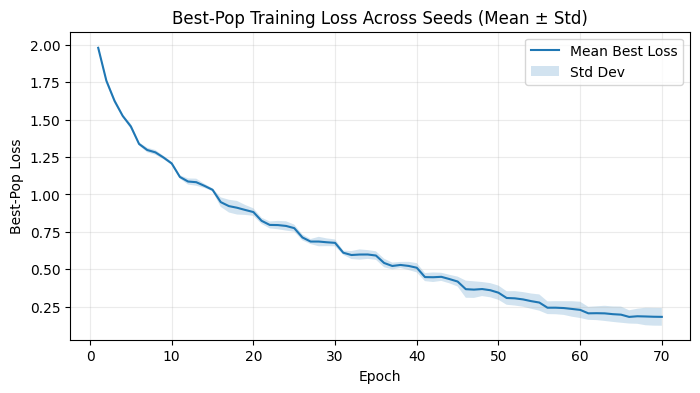

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig6_pbt_bestpop_val_acc_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig6_pbt_bestpop_val_acc_mean_std.pdf


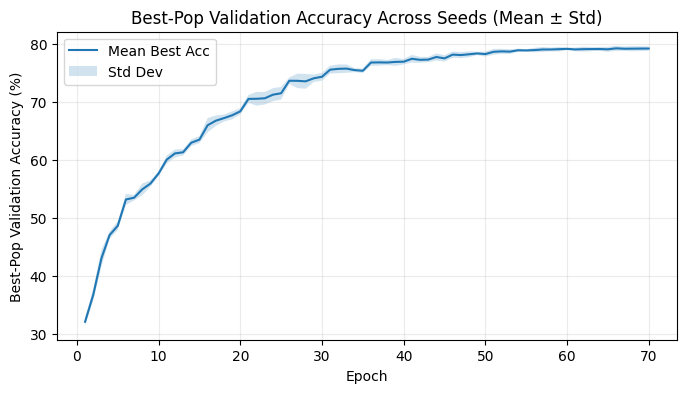

In [4]:
# === Main PBT: aggregate across seeds (Figures 5 & 6) ===
if df_main is not None:
    plot_bestpop_mean_std(
        df_main,
        title_loss='Best-Pop Training Loss Across Seeds (Mean ± Std)',
        title_acc='Best-Pop Validation Accuracy Across Seeds (Mean ± Std)',
        stem_loss='fig5_pbt_bestpop_loss_mean_std',
        stem_acc='fig6_pbt_bestpop_val_acc_mean_std',
    )

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


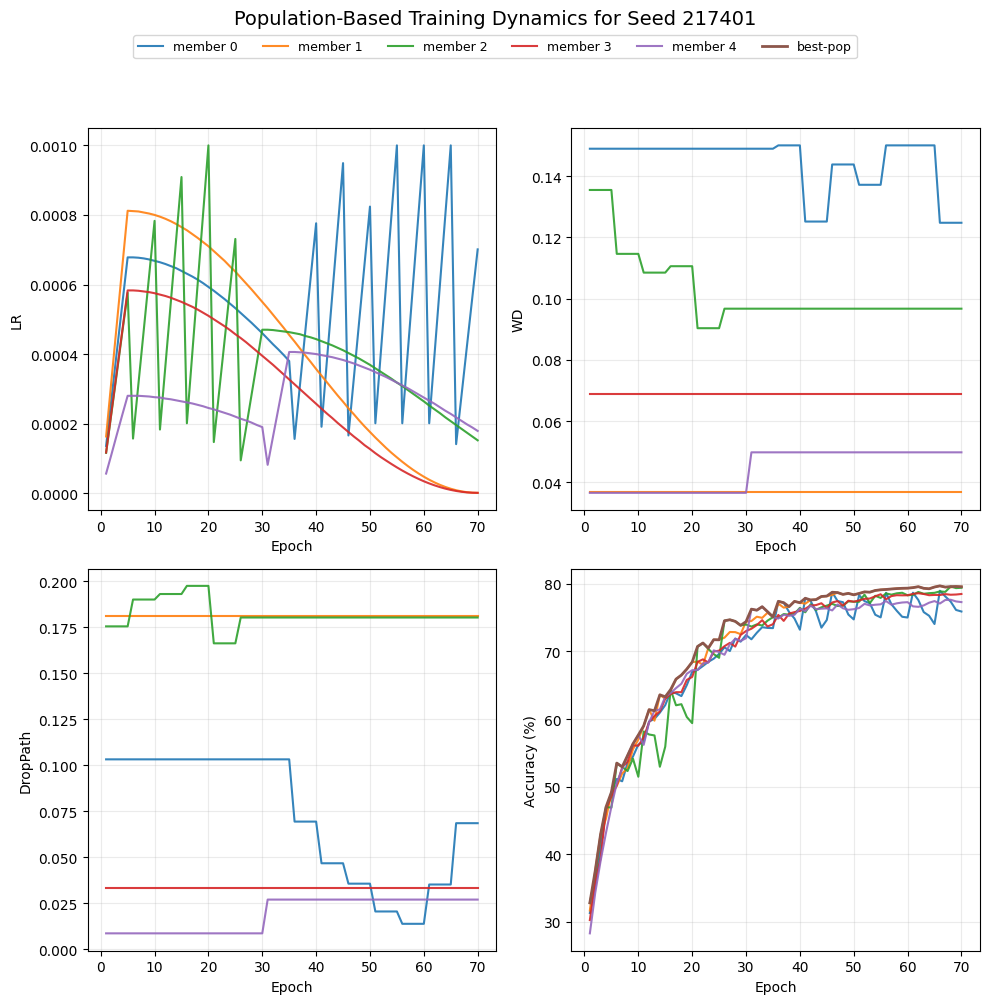

In [5]:
# === Main PBT: representative hyperparameter trajectories (Figure 4) ===
# The paper uses seed 217401 as an example (2×2 hyperparams + val acc).
if df_main is not None and 217401 in set(df_main['seed'].unique()):
    plot_seed_hparams_only(df_main, seed=217401, stem='fig4_pbt_representative_seed_217401')

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


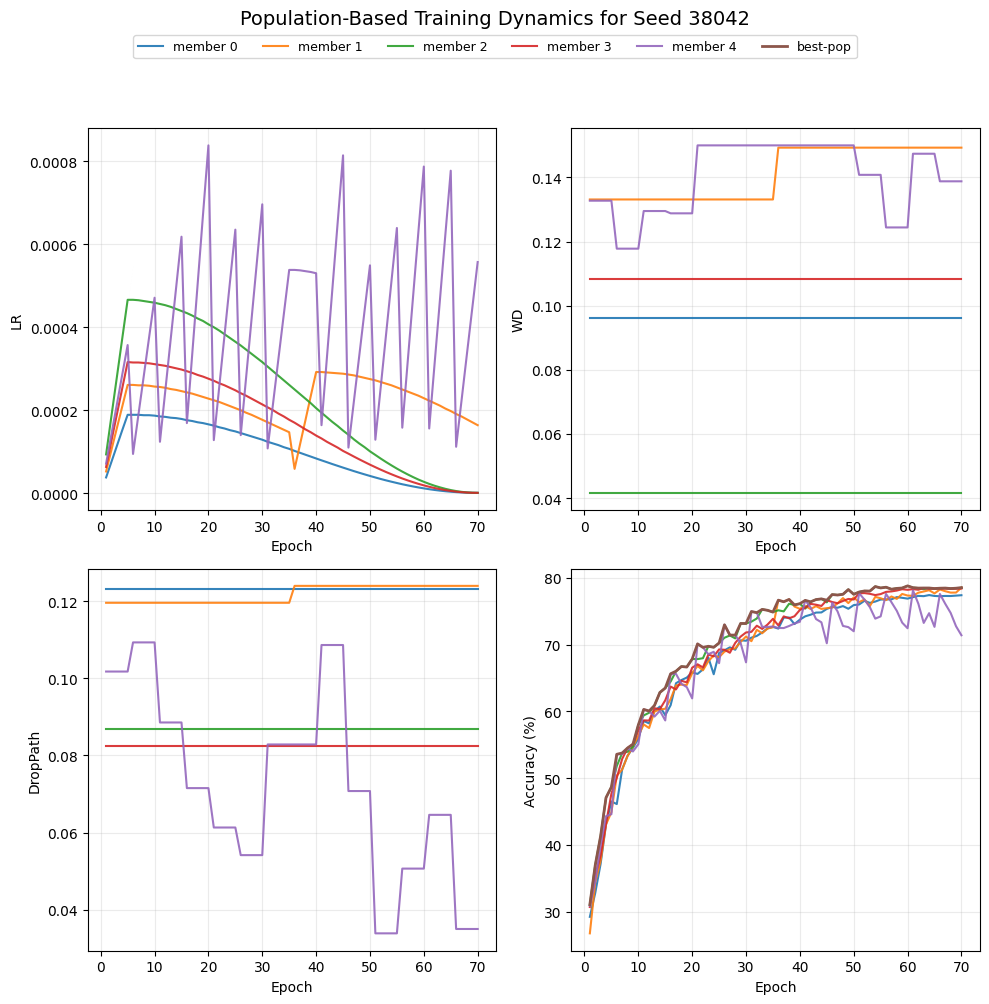

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


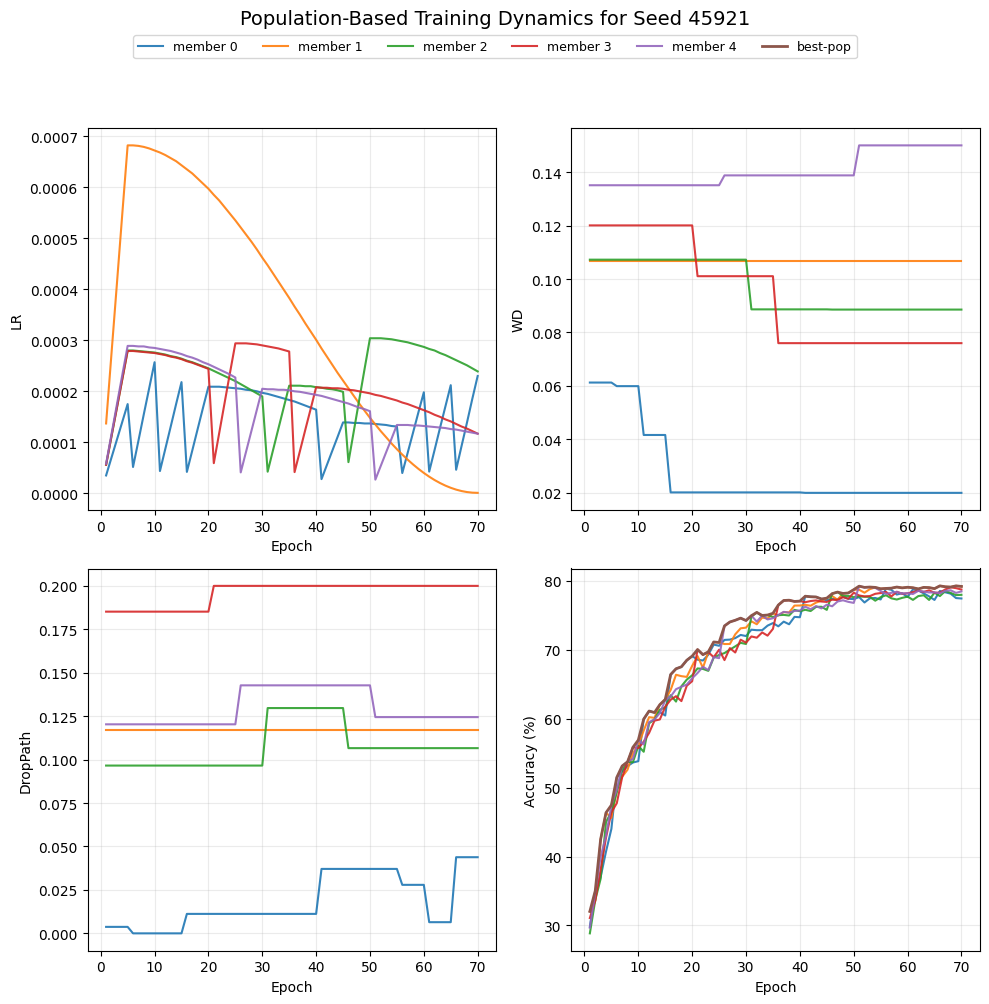

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


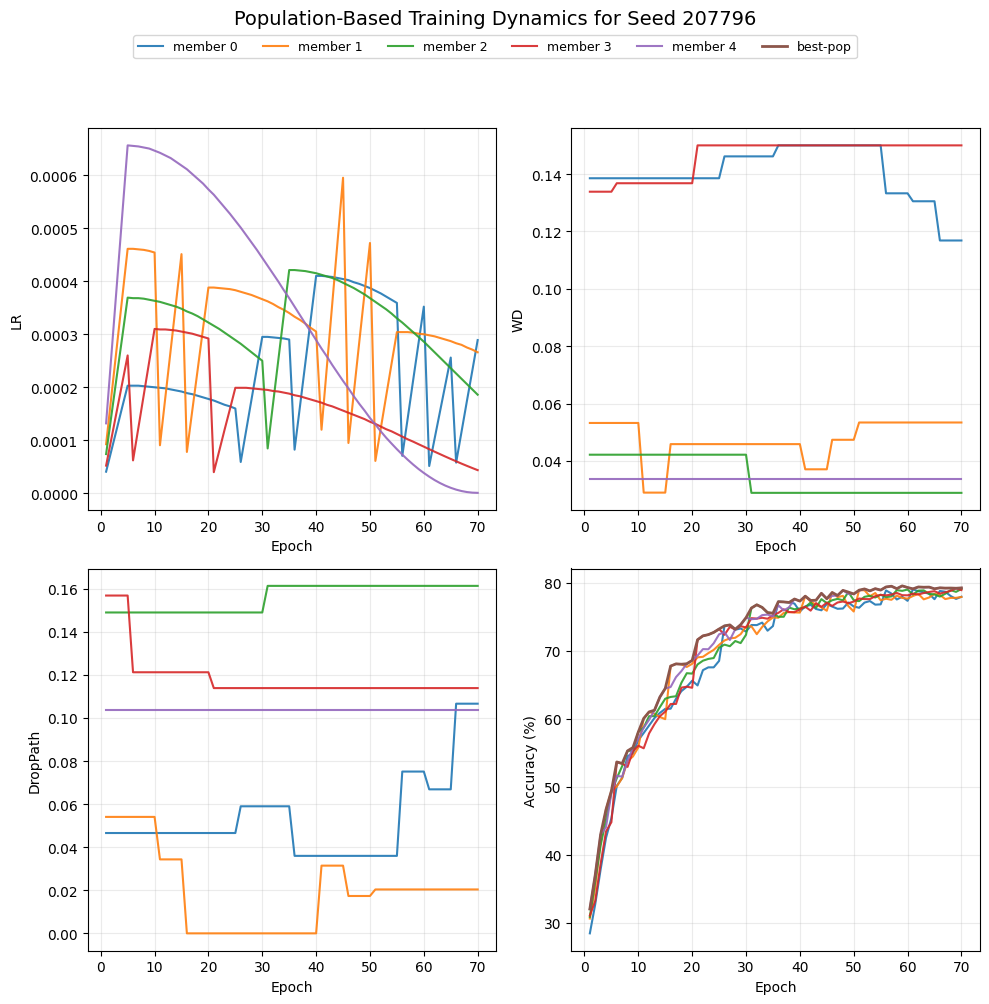

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


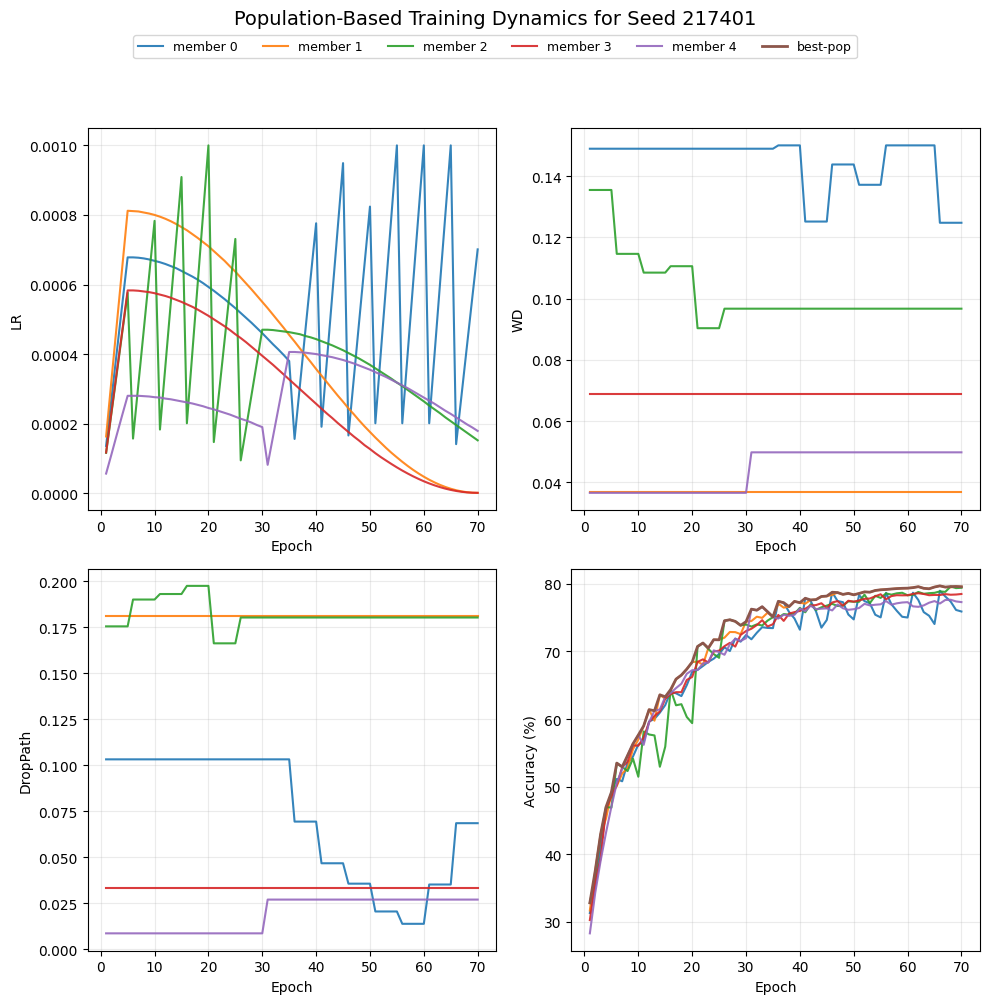

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


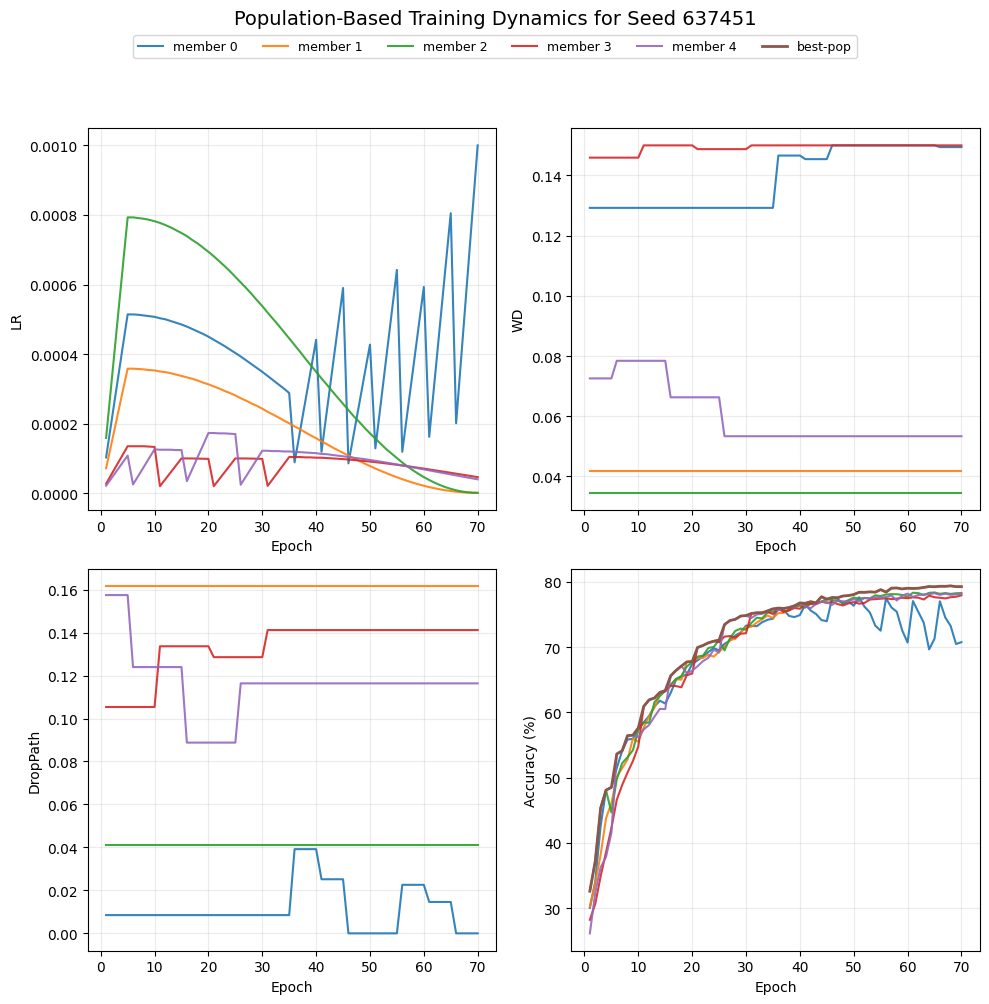

In [6]:
# === Main PBT: per-seed diagnostics (Figures 7–11 style) ===
# The paper shows a subset of seeds; we generate a figure for *every* seed present.

if df_main is not None:
    for s in sorted(df_main['seed'].unique()):
        plot_seed_hparams_only(df_main, seed=s, stem='fig4_pbt_representative_seed_217401')

In [7]:
# === Table 4: final best validation accuracy per seed under PBT ===
# We take best-of-pop validation accuracy at the final epoch.

if df_main is not None:
    best = best_of_population(df_main)
    last_epoch = int(best['epoch'].max())
    table4 = (
        best[best['epoch'] == last_epoch]
        .sort_values('best_val_acc', ascending=False)
        .rename(columns={'best_val_acc': 'Final best val. accuracy (%)'})
        [['seed', 'Final best val. accuracy (%)']]
        .reset_index(drop=True)
    )

    table4_out = OUT_DIR / 'table4_pbt_final_best_val_acc_per_seed.csv'
    table4.to_csv(table4_out, index=False)
    print(f"Saved: {table4_out}")
    table4

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/table4_pbt_final_best_val_acc_per_seed.csv


In [8]:
# === Table 5 (optional): replacement / copy events per seed ===
# If you have the companion XLSX, we export the 'copy_events' sheet to CSV for convenience.

xlsx_main = DATA_DIR / 'pbt_experiment_pdfs_parsed.xlsx'
if xlsx_main.exists():
    try:
        copy_events = pd.read_excel(xlsx_main, sheet_name='copy_events')
        out = OUT_DIR / 'table5_pbt_copy_events.csv'
        copy_events.to_csv(out, index=False)
        print(f"Saved: {out}")
        copy_events.head(20)
    except Exception as e:
        print("Could not read 'copy_events' sheet:", e)

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/table5_pbt_copy_events.csv


Saved: Plotting Code/fig15_pbt_bs_bestpop_loss_mean_std.png
Saved: Plotting Code/fig15_pbt_bs_bestpop_loss_mean_std.pdf


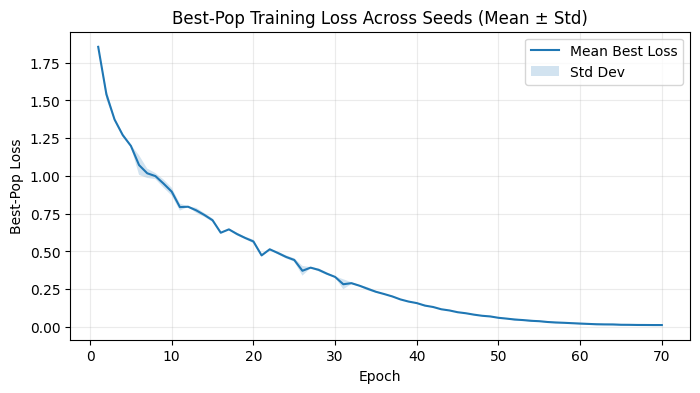

Saved: Plotting Code/fig16_pbt_bs_bestpop_val_acc_mean_std.png
Saved: Plotting Code/fig16_pbt_bs_bestpop_val_acc_mean_std.pdf


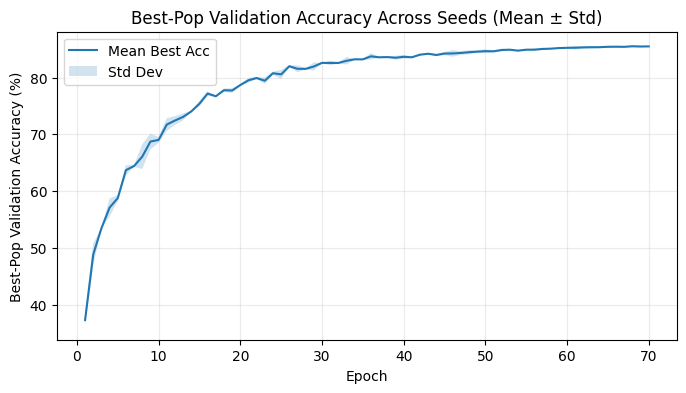

In [16]:
# === Ablation 1: batch-size mutations (Figures 12–13 style) === summary#
# === Ablation 3: larger weight-decay bounds + batch-size tuning (Figures 15–18) ===
if df_bs is not None:
    # Aggregate across seeds (Figures 15 & 16)
    plot_bestpop_mean_std(
        df_bs,
        title_loss='Best-Pop Training Loss Across Seeds (Mean ± Std)',
        title_acc='Best-Pop Validation Accuracy Across Seeds (Mean ± Std)',
        stem_loss='fig15_pbt_bs_bestpop_loss_mean_std',
        stem_acc='fig16_pbt_bs_bestpop_val_acc_mean_std',
    )

Saved: Plotting Code/fig12_13_pbt_batchsize_seed_38042.png
Saved: Plotting Code/fig12_13_pbt_batchsize_seed_38042.pdf


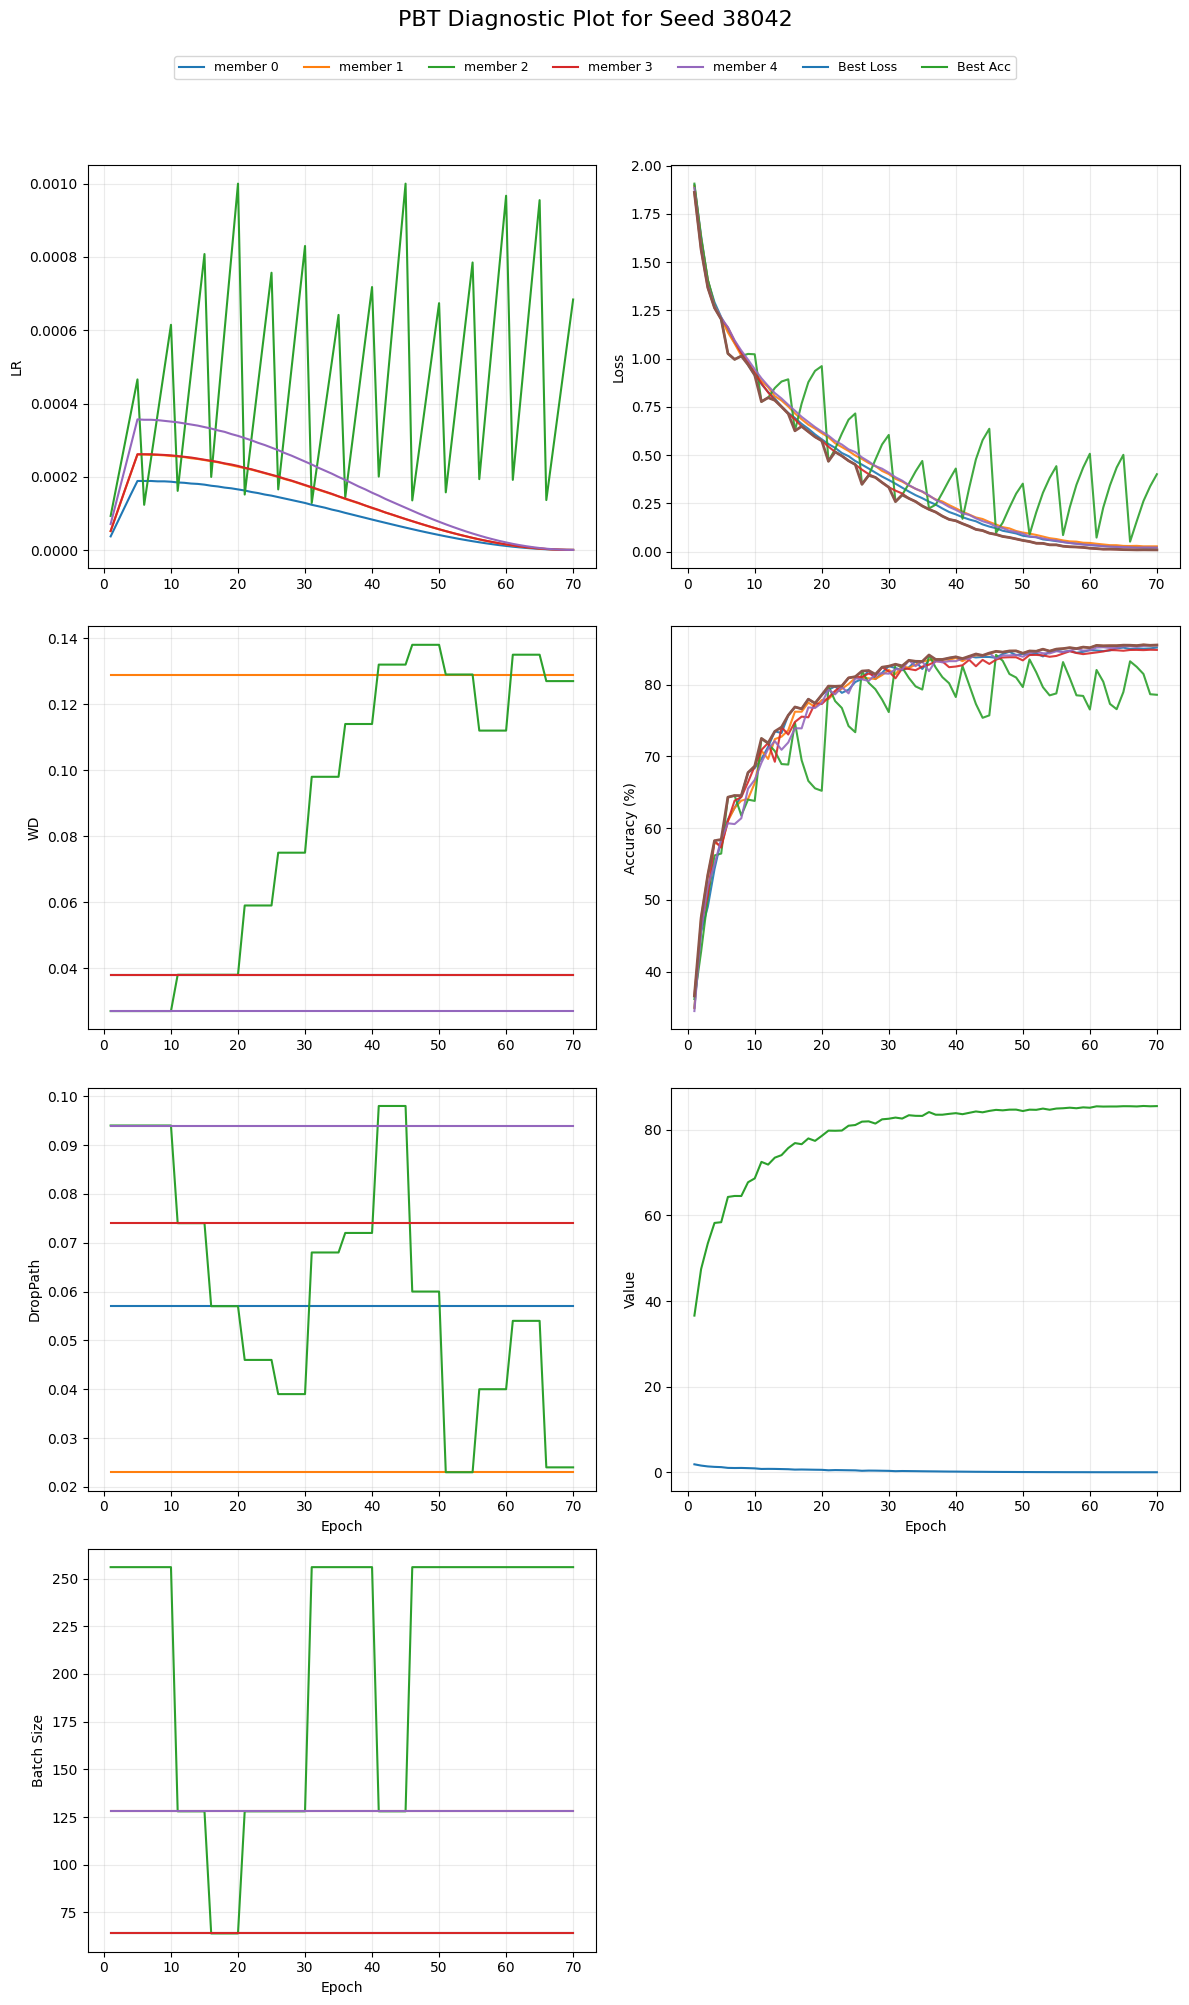

Saved: Plotting Code/fig12_13_pbt_batchsize_seed_217401.png
Saved: Plotting Code/fig12_13_pbt_batchsize_seed_217401.pdf


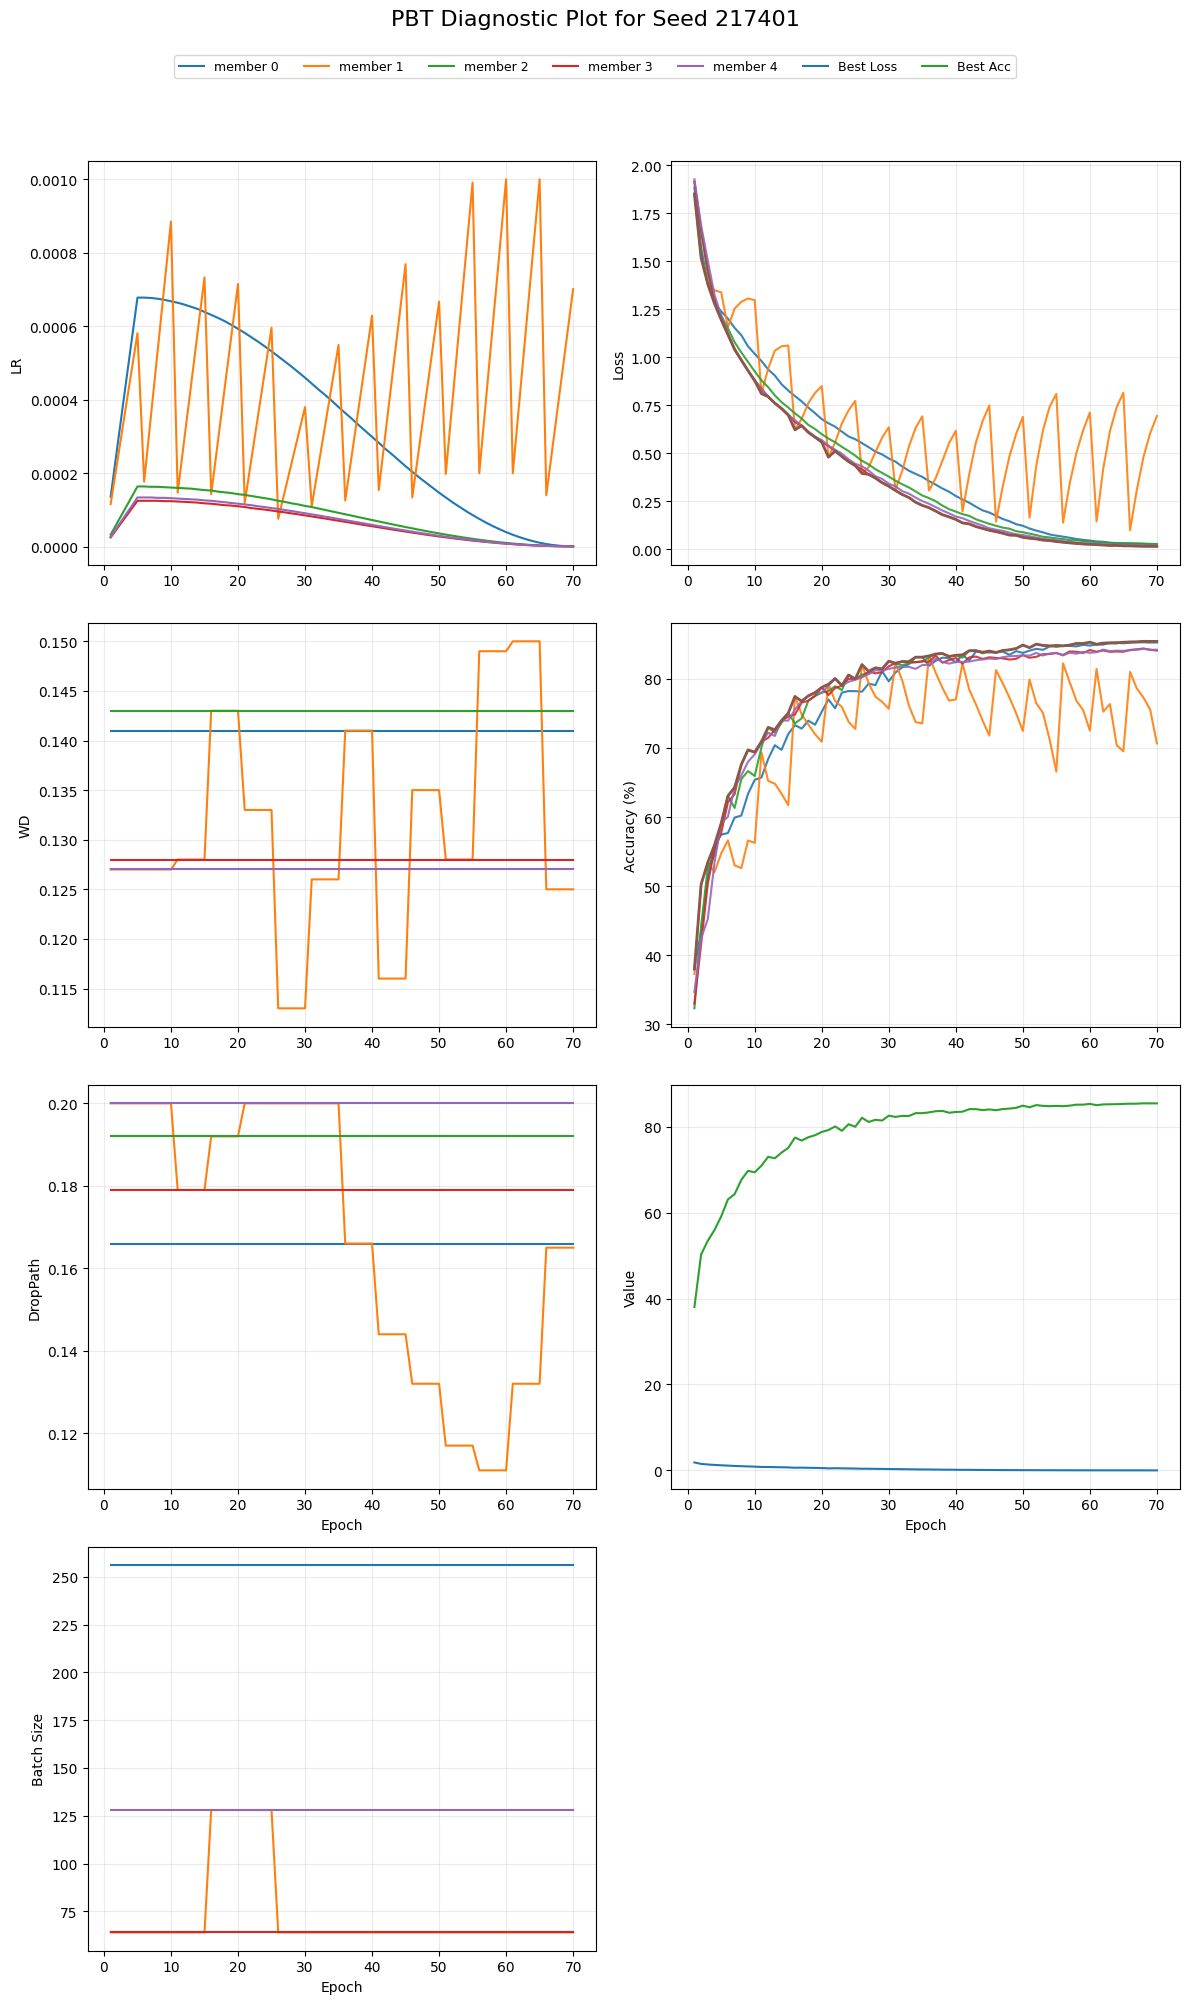

In [14]:
# === Ablation 1: batch-size mutations (Figures 12–13 style) ===
# The paper's batch-size ablation figures keep the same 3×2 layout (no extra batch-size panel).
if df_bs is not None:
    for s in sorted(df_bs['seed'].unique()):
        plot_seed_dynamics(df_bs, seed=int(s), stem=f'fig12_13_pbt_batchsize_seed_{int(s)}', include_batch_size_panel=True)

In [10]:
# === Ablation 2: larger weight-decay bounds only (Figure 14 style) ===
if df_wd is not None:
    for s in sorted(df_wd['seed'].unique()):
        plot_seed_dynamics(df_wd, seed=int(s), stem=f'fig14_pbt_wd_ablation_seed_{int(s)}', include_batch_size_panel=False)

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig15_pbt_wd_bs_bestpop_loss_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig15_pbt_wd_bs_bestpop_loss_mean_std.pdf


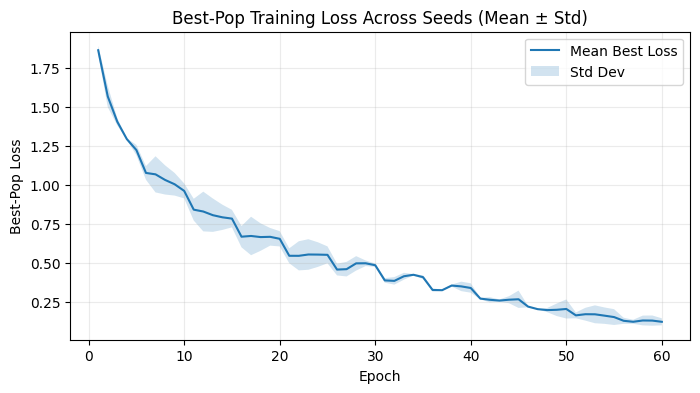

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig16_pbt_wd_bs_bestpop_val_acc_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig16_pbt_wd_bs_bestpop_val_acc_mean_std.pdf


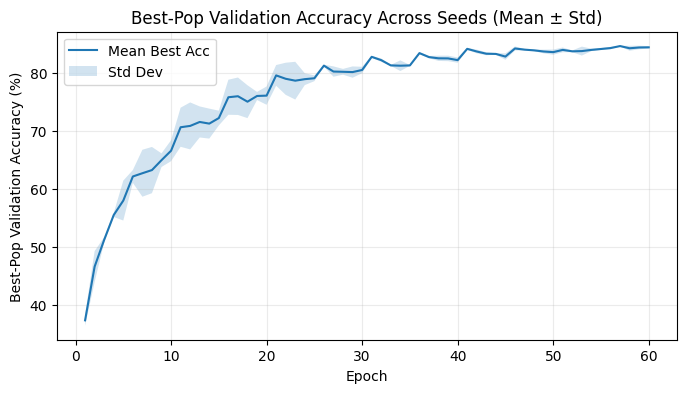

In [11]:
# === Ablation 3: larger weight-decay bounds + batch-size tuning (Figures 15–18) ===
if df_bsw is not None:
    # Aggregate across seeds (Figures 15 & 16)
    plot_bestpop_mean_std(
        df_bsw,
        title_loss='Best-Pop Training Loss Across Seeds (Mean ± Std)',
        title_acc='Best-Pop Validation Accuracy Across Seeds (Mean ± Std)',
        stem_loss='fig15_pbt_wd_bs_bestpop_loss_mean_std',
        stem_acc='fig16_pbt_wd_bs_bestpop_val_acc_mean_std',
    )

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_38042.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_38042.pdf


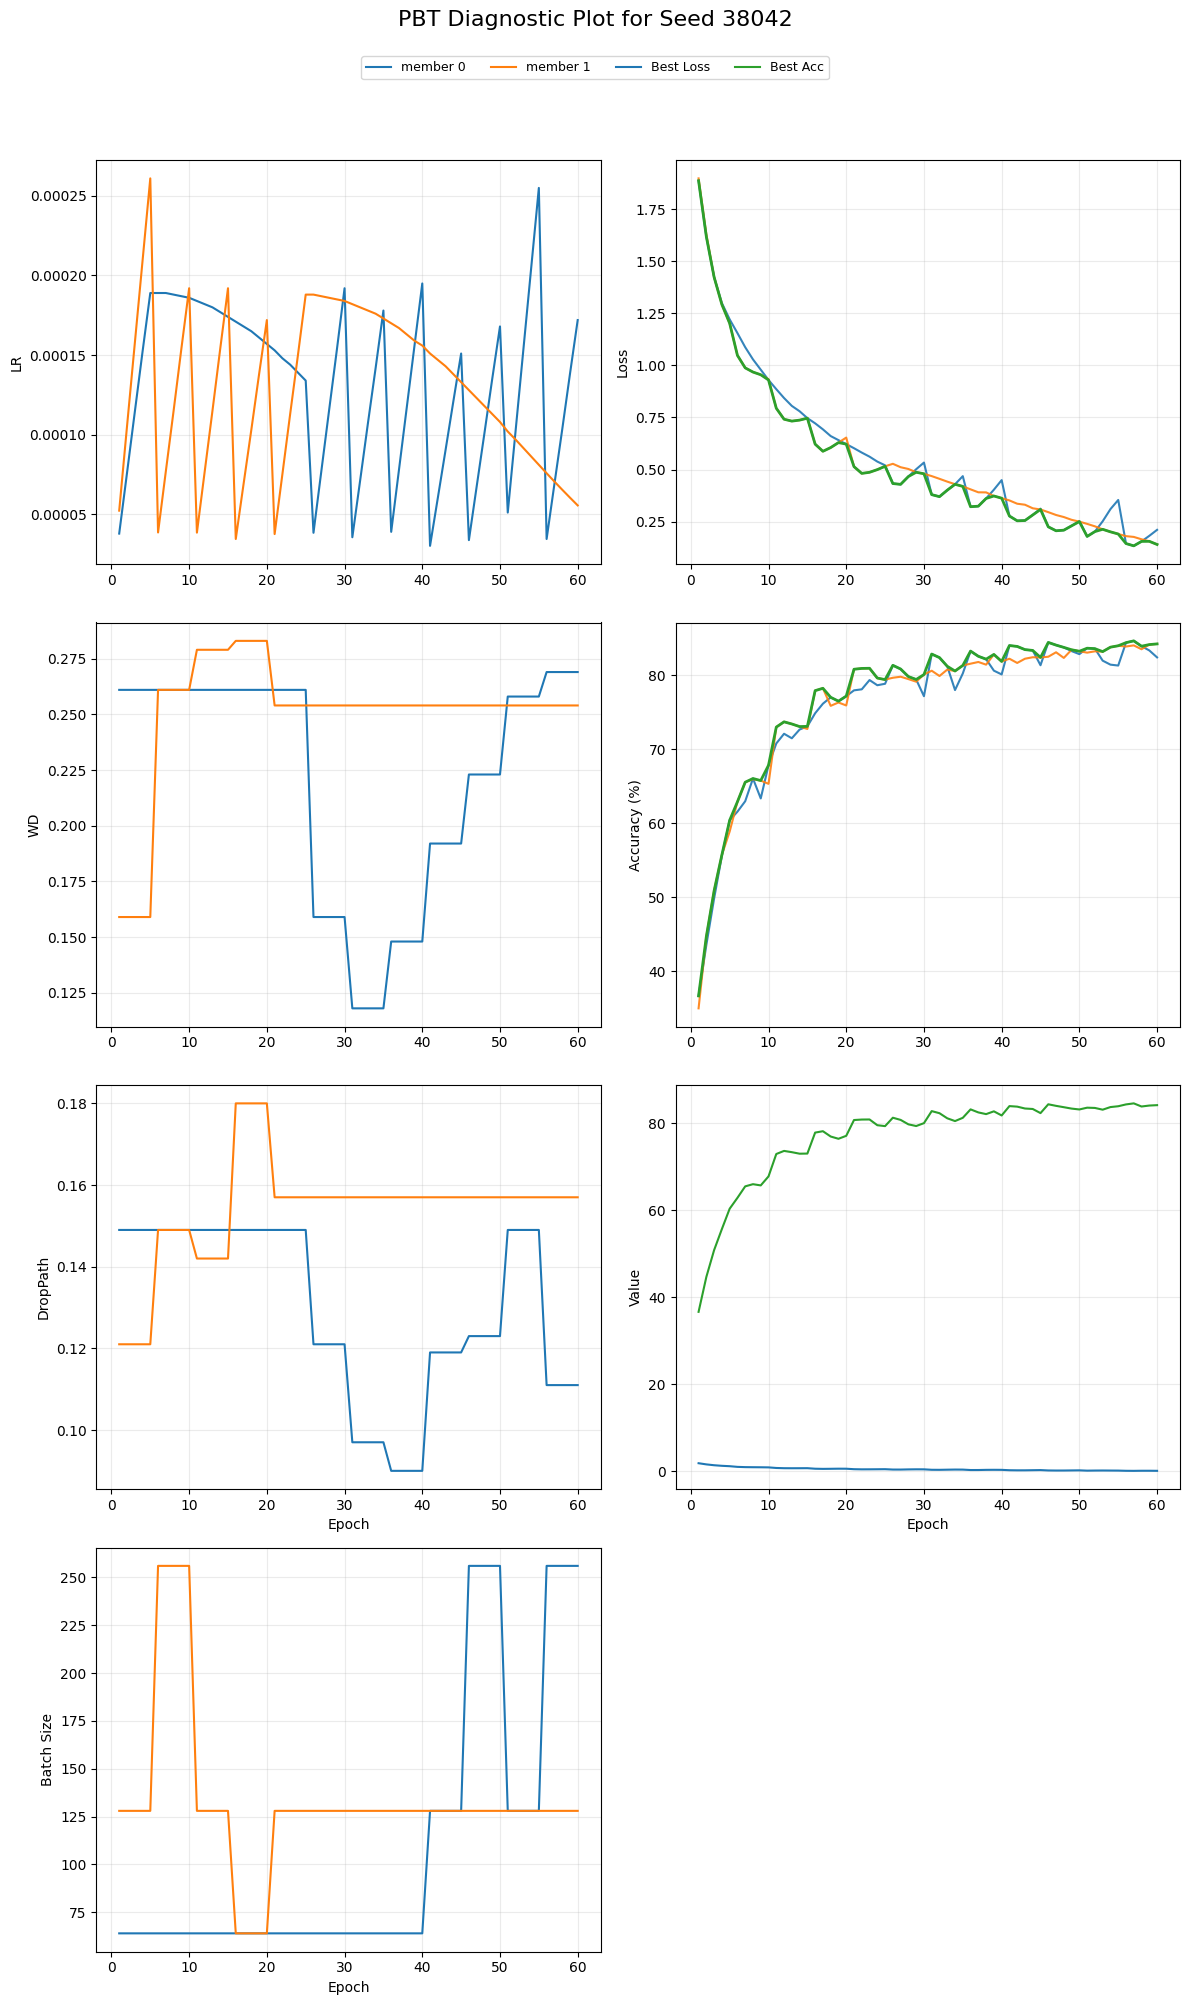

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_217401.pdf


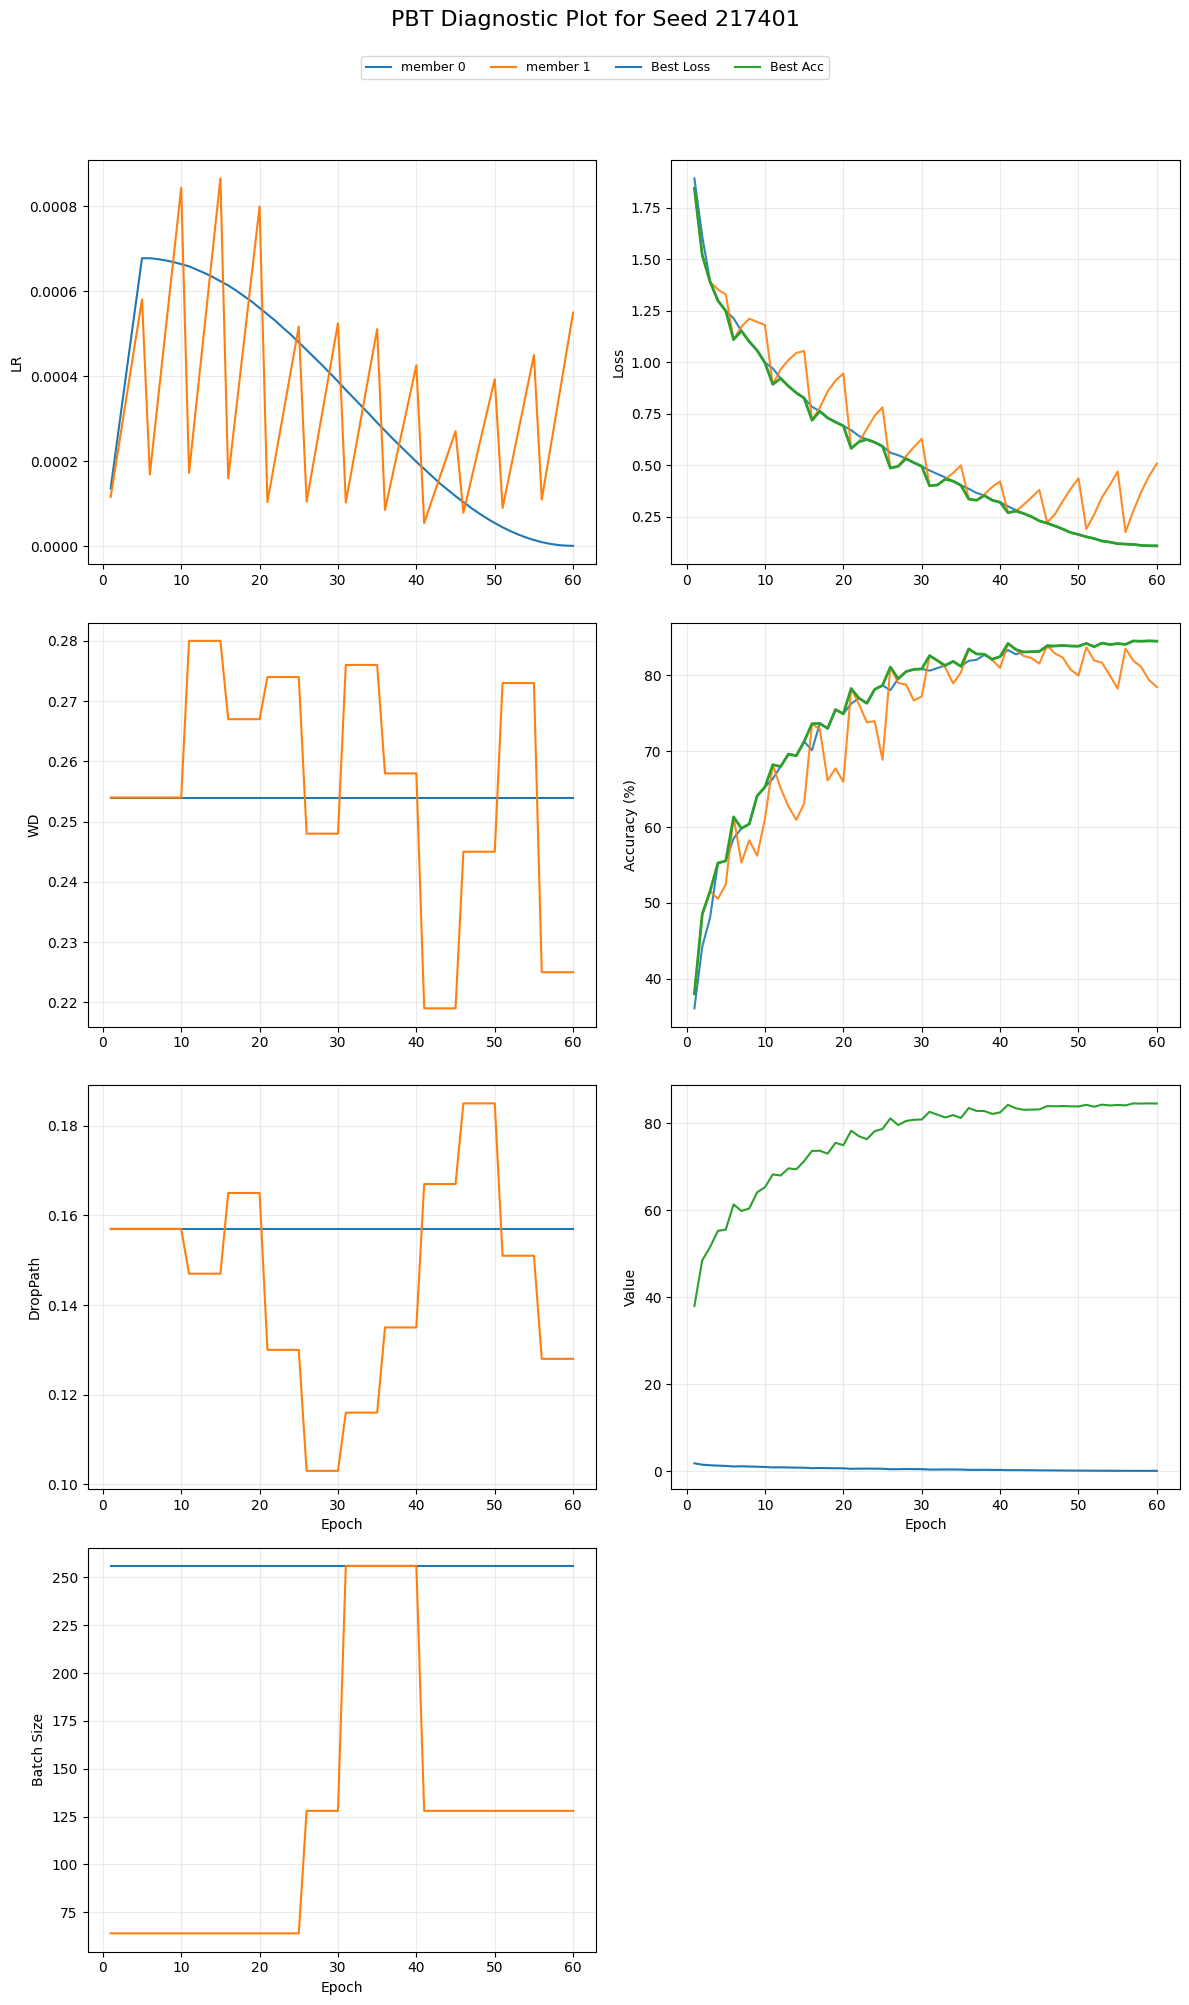

In [12]:
    # Per-seed diagnostics (Figures 17–18 style)
for s in sorted(df_bsw['seed'].unique()):
    plot_seed_dynamics(df_bsw, seed=int(s), stem=f'fig17_18_pbt_wd_bs_seed_{int(s)}', include_batch_size_panel=True)

In [13]:
# ============================
# Tables 1, 5, 6 (from processed PBT CSVs)
# Uses: df_main, df_bs, df_wd, df_bsw
# ============================

import math
import numpy as np
import pandas as pd
from pathlib import Path

try:
    from IPython.display import display
except Exception:
    display = None

# ---- constants (adjust if your train set size differs) ----
N_TRAIN = 50_000
Z_95 = 1.96  # normal approx for 95% CI

OUT_DIR = Path("Plotting Code")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- helpers ----------------
def best_of_population(df: pd.DataFrame) -> pd.DataFrame:
    """Per-(seed, epoch): best loss (min) and best validation acc (max)."""
    req = {"seed", "epoch", "loss", "test_acc_pct"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"best_of_population missing columns: {sorted(missing)}")
    g = df.groupby(["seed", "epoch"], as_index=False).agg(
        best_loss=("loss", "min"),
        best_val_acc=("test_acc_pct", "max"),
    )
    return g.sort_values(["seed", "epoch"]).reset_index(drop=True)

def ci95_half_width(vals) -> float:
    vals = np.asarray(vals, dtype=float)
    vals = vals[~np.isnan(vals)]
    n = len(vals)
    if n < 2:
        return np.nan
    return Z_95 * np.std(vals, ddof=1) / math.sqrt(n)

def format_mean_ci(mean, ci):
    return f"{mean:.2f}" if np.isnan(ci) else f"{mean:.2f} ± {ci:.2f}"

def _find_first_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def steps_by_seed(df: pd.DataFrame, default_bs: int = 256) -> tuple[pd.Series, str]:
    """
    Compute total optimizer steps per seed for a PBT run using per-epoch batch size if available.

    Preferred batch size columns (in order):
      - pbt_batch_size
      - batch_size / bs / BatchSize

    Fallback:
      - assume constant batch size = default_bs and compute steps from (#unique seed,member,epoch)
    Returns:
      (steps_series indexed by seed, note_string)
    """
    if "seed" not in df.columns:
        raise ValueError("steps_by_seed: missing column 'seed'")

    member_col = "member" if "member" in df.columns else None
    epoch_col  = "epoch"  if "epoch"  in df.columns else None

    bs_col = _find_first_col(df, ["pbt_batch_size", "batch_size", "BatchSize", "bs", "BS"])

    # Need epoch to do anything sensible
    if epoch_col is None:
        raise ValueError("steps_by_seed: missing column 'epoch'")

    key = ["seed"]
    if member_col is not None:
        key.append(member_col)
    key.append(epoch_col)

    # Deduplicate to one row per (seed, member, epoch)
    sub = df[key].drop_duplicates().copy()

    if bs_col is not None:
        # attach bs per (seed, member, epoch) via first() from the raw df
        bs_map = df[key + [bs_col]].dropna().groupby(key, as_index=False)[bs_col].first()
        sub = sub.merge(bs_map, on=key, how="left")
        if sub[bs_col].isna().any():
            # if some missing, fill with default and note it
            sub[bs_col] = sub[bs_col].fillna(default_bs)
            note = f"Used '{bs_col}' when available; filled missing with default_bs={default_bs}."
        else:
            note = f"Used '{bs_col}' to compute steps."
        sub["_steps"] = np.ceil(N_TRAIN / sub[bs_col].astype(float))
    else:
        # no BS column: assume constant batch size
        note = f"No batch-size column found; assumed constant batch size default_bs={default_bs}."
        sub["_steps"] = math.ceil(N_TRAIN / float(default_bs))

    steps = sub.groupby("seed")["_steps"].sum().sort_index()
    return steps, note

def final_best_acc_by_seed(df: pd.DataFrame) -> pd.Series:
    """
    Per seed: best-of-pop validation accuracy (%) at the FINAL epoch.
    """
    best = best_of_population(df)
    final_epoch = best.groupby("seed")["epoch"].max().rename("final_epoch")
    best = best.merge(final_epoch, on="seed", how="left")
    best_final = best[best["epoch"] == best["final_epoch"]]
    out = best_final.set_index("seed")["best_val_acc"].sort_index()
    return out

# ---------------------------
# TABLE 1 (structured; PBT variants only)
# ---------------------------
methods = {
    "PBT (base)": df_main,
    "PBT (BS-ablation)": df_bs,
    "PBT (WD-ablation)": df_wd,
    'PBT (WD+BS ablation':   df_bsw,
}

rows_t1 = []
steps_notes = {}

for name, dfx in methods.items():
    acc_per_seed = final_best_acc_by_seed(dfx)
    acc_ci = ci95_half_width(acc_per_seed.values)

    steps_per_seed, note = steps_by_seed(dfx, default_bs=256)
    steps_notes[name] = note

    # Match your paper convention: report steps as mean ± std across seeds (esp. for WD+BS).
    print('steps per seed were', steps_per_seed.values)
    steps_mean = float(np.mean(steps_per_seed.values))
    steps_sd = float(np.std(steps_per_seed.values, ddof=1)) if len(steps_per_seed) >= 2 else np.nan
    if name == 'PBT (WD+BS ablation)':
        scale_factor = 1
        steps_str = f"{(scale_factor)*steps_mean:,.0f} ± {(scale_factor)*Z_95*steps_sd:,.0f}"
    else:
        steps_str = f"{steps_mean:,.0f}" if np.isnan(steps_sd) else f"{steps_mean:,.0f} ± {Z_95*steps_sd:,.0f}"

    rows_t1.append({
        "Method": name,
        "N seeds": int(len(acc_per_seed)),
        "Final best val acc (%) (mean ± 95% CI over seeds)": format_mean_ci(float(acc_per_seed.mean()), acc_ci),
        "Total optimizer steps per seed (mean ± 95% CI seeds)": steps_str,
    })

table1 = pd.DataFrame(rows_t1)

print("\n=== TABLE 1 (structured; PBT variants) ===")
if display is not None:
    display(table1)
else:
    print(table1.to_string(index=False))

# Save + also print step-computation notes (useful for sanity checking)
table1_path = OUT_DIR / "table1_pbt_variants_structured.csv"
table1.to_csv(table1_path, index=False)
print(f"Saved: {table1_path}")

print("\n[Table 1 notes]")
for k, v in steps_notes.items():
    print(f"- {k}: {v}")

# ---------------------------
# TABLE 5 (structured; base PBT final best per seed)
# ---------------------------
table5 = (
    final_best_acc_by_seed(df_main)
    .reset_index()
    .rename(columns={"seed": "Seed", "best_val_acc": "Final best val acc (%)"})
    .sort_values("Seed")
    .reset_index(drop=True)
)

print("\n=== TABLE 5 (structured; base PBT final best per seed) ===")
if display is not None:
    display(table5)
else:
    print(table5.to_string(index=False))

table5_path = OUT_DIR / "table5_base_pbt_final_best_per_seed.csv"
table5.to_csv(table5_path, index=False)
print(f"Saved: {table5_path}")

steps per seed were [68600. 68600. 68600. 68600. 68600.]
steps per seed were [184770. 201400.]


AttributeError: 'NoneType' object has no attribute 'columns'